In [273]:
# imports
import torch
import torch.nn as nn
# import torchaudio --> dunno what this is for
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# adding the data utils 
from data_utils import *

# Ignore warnings >:D
import warnings
warnings.filterwarnings("ignore")
print('sanity')

sanity


In [274]:
# Daniels looks way nicer, stealing from him :D
data_850 = pd.read_csv('NA850data_2000-2014.csv')
data_w_extreme = add_extreme(data_850)

In [275]:
# get scaled provided data with deltas and time added
X = data_850.drop(columns=['LH'])
X = add_deltas_and_time(X)
X = scale_data(X)

# do y's need to be scaled, as well?

y = data_850['LH']
y_extreme = data_w_extreme['Extreme']

X.head()
y_extreme

0        0
1        0
2        1
3        0
4        0
        ..
20299    0
20300    0
20301    0
20302    0
20303    0
Name: Extreme, Length: 20304, dtype: int32

In [276]:
len(y_extreme[y_extreme == 1]), len(y_extreme)

(2106, 20304)

In [277]:
from imblearn.under_sampling import NearMiss

undersampler = NearMiss(sampling_strategy=1)
X_under, y_extreme_under = undersampler.fit_resample(X, y_extreme)
y_under = y[undersampler.sample_indices_]
y_extreme_under

0       0
1       0
2       0
3       0
4       0
       ..
4207    1
4208    1
4209    1
4210    1
4211    1
Name: Extreme, Length: 4212, dtype: int32

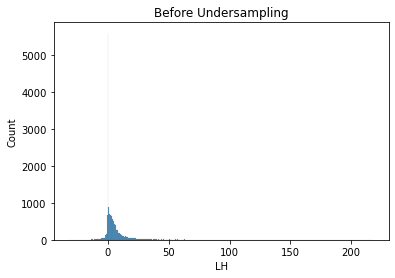

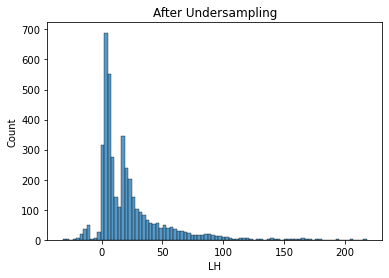

In [278]:
import seaborn as sns
sns.histplot(y)
plt.title("Before Undersampling")
plt.show()
sns.histplot(y_under)
plt.title("After Undersampling")
plt.show()

# NNC

In [279]:
# Dataset Definition

class CustomWaveData(Dataset):
    def __init__(self, dataframe, ys):
        self.y = torch.tensor(ys.values,dtype=torch.float32)
        self.x = torch.tensor(dataframe.values,dtype=torch.float32)
        self.size = len(dataframe)
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.size

In [280]:
from sklearn.model_selection import train_test_split

# split the data
X_train, X_test, y_train, y_test = train_test_split(X_under, y_extreme_under, test_size=0.2, random_state=42)

training_data = CustomWaveData(X_train,y_train)
test_data = CustomWaveData(X_test, y_test)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

In [281]:
# define the model -- as of now the same shape of the previous one
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # initialize the sequential/feedforward net here
        self.linear_relu_stack = nn.Sequential(
        
        # input layer,
        nn.Linear(20,20),
        # relu activation
        nn.ReLU(),     
            
        # hidden layer 1
        nn.Linear(20,20),
        nn.ReLU(),
            
        nn.Dropout(p=.3),    
            
        # hidden layer 2
        nn.Linear(20,20),
        nn.ReLU(),
            
        nn.Dropout(p=.3),    
            
        # hidden layer 3
        nn.Linear(20,20),
        nn.ReLU(),    
            
        # output -> we can always play around with the shape of the network
        # I just want to see that this works for now
        nn.Linear(20,1)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        logits = self.sigmoid(logits)
        return logits

In [282]:
# testing
model = NeuralNetwork()
test_data = training_data[0]
X,y = test_data
print(X)
test_res = model(X)
print(test_res.item())
print(y)

tensor([ 0.2583,  0.5263, -0.1807, -0.2545,  0.1338, -0.2141,  0.0701, -0.2522,
         1.1905,  0.3694,  0.6306, -0.1723,  0.6838, -0.5256,  0.3730, -0.3381,
        -0.1062, -0.2400,  0.0000,  0.0000])
0.5535151362419128
tensor(0.)


In [283]:
# defining the loss
loss_fn = nn.BCELoss()

# define the optimization: Adam, lr = learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=.001, weight_decay = .01)

In [284]:
# training loop
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    # correct is TP
    correct = 0
    fp = 0
    fn = 0
    
    train_losses = []
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        y = y.unsqueeze(1)
        
        # testing
        # print(f"X: {X}")
        # print(f"y: {y}")
        # print(f"pred: {pred.round()}")
        
        for i in range(len(pred)):
            if pred[i] > .5:
                if y[i] == 1:
                    correct += 1
                else:
                    fp += 1
            else:
                if y[i] == 1:
                    fn += 1
                else:
                    correct += 1
            
        loss = loss_fn(pred,y)
        # print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        # correct += (((pred > .5) * 1) == y).sum()
        # fp += (((pred > .5) * 1) != y).sum()
        # fn += (((pred < .5) * 1) != y).sum()
        
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    print(f"Train Size: {size}")
    print(f"Train correct: {correct}")
    print(f"Train fp: {fp}")
    print(f"Train fn: {fn}")
    print(f"Train Acc: {correct/size}")
    print(f"Train f1: {(2*correct) / ((2*correct) + fp + fn)}")
    return train_losses

In [285]:
# test loop
def test(dataloader, model, loss_fn):
    # size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    # correct is TP
    correct = 0
    fp = 0
    fn = 0
    
    with torch.no_grad():
        for X, y in (dataloader):
            pred = model(X)
            y = y.unsqueeze(1)
            
            
            for i in range(len(pred)):
                # print(pred[i], y[i]
                if pred[i] > .5:
                    if y[i] == 1:
                        correct += 1
                    else:
                        fp += 1
                else:
                    if y[i] == 1:
                        fn += 1
                    else:
                      correct += 1
            
            # # testing
            # print(f"X: {X}")
            # print(f"y: {y}")
            # print(f"pred: {pred.round()}")
            
            test_loss += loss_fn(pred, y).item()
            # correct += (((pred > .5) * 1) == y).sum()
    print(f"Test correct: {correct}")
    print(f"Test fp: {fp}")
    print(f"Test fn: {fn}")        
    print(f"Test Avg Loss: {test_loss/num_batches}, Test Acc: {correct/len(dataloader.dataset)}")
    print(f"Test f1: {(2*correct) / ((2*correct) + fp + fn)}")
    return test_loss

In [286]:
epochs = 20
train_losses = []
test_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses += train(train_dataloader, model, loss_fn, optimizer)
    test_losses.append(test(test_dataloader, model, loss_fn))
print("Done!")

Epoch 1
-------------------------------
loss: 0.697802  [   64/ 3369]
Train Size: 3369
Train correct: 1713
Train fp: 1654
Train fn: 2
Train Acc: 0.5084594835262689
Train f1: 0.6741440377804014
Test correct: 393
Test fp: 450
Test fn: 0
Test Avg Loss: 0.6206655119146619, Test Acc: 0.46619217081850534
Test f1: 0.6359223300970874
Epoch 2
-------------------------------
loss: 0.629744  [   64/ 3369]
Train Size: 3369
Train correct: 2522
Train fp: 651
Train fn: 196
Train Acc: 0.7485900860789552
Train f1: 0.8562213546087252
Test correct: 733
Test fp: 55
Test fn: 55
Test Avg Loss: 0.4290864531482969, Test Acc: 0.8695136417556346
Test f1: 0.9302030456852792
Epoch 3
-------------------------------
loss: 0.370046  [   64/ 3369]
Train Size: 3369
Train correct: 2936
Train fp: 151
Train fn: 282
Train Acc: 0.8714752151973879
Train f1: 0.9313243457573355
Test correct: 749
Test fp: 37
Test fn: 57
Test Avg Loss: 0.3127412870526314, Test Acc: 0.8884934756820878
Test f1: 0.9409547738693468
Epoch 4
--------